In [1]:
import sys
sys.path.append('../src/')
from vi_hrg_fix import *
from utils import c2d, hyperdist, p_hd, polar2cart, warn_tensor, unit_circle, arcosh
from torch import autograd
torch.manual_seed(42)

In [2]:
def noise_r(x, R, rel_var=0.1, epsilon=1e-4):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.clamp(rs, min=0+epsilon, max=R.item()-epsilon)

In [3]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

In [4]:
logit = lambda x: (x/(1-x)).log()

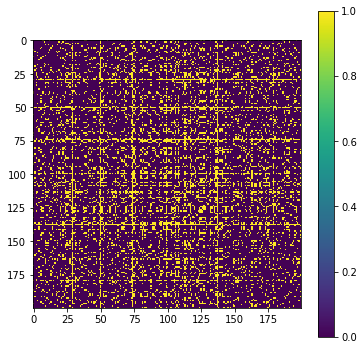

In [5]:
N = 200
R = torch.tensor([5.0]).double()
alpha = .9
T = 0.1

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
G.show()
#G.plot()

In [6]:
r_init = noise_r(r, R, rel_var=0.05)
phi_init = noise_phi(theta, 0.05)

r_loc_init = logit(r_init/R)*R/5
r_scale_init = torch.ones([N]).double().log()
phi_loc_init = polar2cart(1, phi_init)
phi_scale_init = (torch.ones([N]).double()*30).log()

In [7]:
R_conc_init = torch.tensor(10.).log()
R_scale_init = torch.tensor(1.).log()
alpha_conc_init = torch.tensor(.5).log()
alpha_scale_init = torch.tensor(.5).log()
T_init = torch.tensor([3.,10.]).log()

In [8]:
dataloader = DataLoader(EdgesDataset(A), batch_size=int(N**2/8), shuffle=True, num_workers=0)
vi = VI_HRG(N,20, init_values={'rs_loc':r_loc_init,
                                'rs_scale':r_scale_init,
                              'phis_loc':phi_loc_init,
                              'phis_scale':phi_scale_init, 
                              'R_conc':R_conc_init, 
                              'R_scale':R_scale_init,
                              'alpha_conc':alpha_conc_init,
                              'alpha_scale':alpha_scale_init,
                              'T':T_init},
           fixed={'R':None, 
                  'T':0.1,
                  'alpha':None},
           priors={'R_p':torch.tensor([20., 0.4]), 
                    'T_p':None,
                    'alpha_p':torch.tensor([27., 0.03])},)
#vi.dataloader = dataloader
#vi.optimizer = torch.optim.RMSprop(vi.parameters())
#vi.optimizer.lr

In [9]:
with autograd.detect_anomaly():
    vi.train(dataloader, lrs=0.1, debug=False, epochs=10)
    #vi.train(dataloader, lrs=0.01, debug=False, epochs=30)

>>>>>>>>>>>> Start training...


../src/utils.py:126: UserWarning: p_raw has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))


Epoch 1 | LR: 0.10 | Total loss: 101695.35 | Epoch time 3.56
Epoch 2 | LR: 0.10 | Total loss: 74503.53 | Epoch time 3.25
Epoch 3 | LR: 0.10 | Total loss: 69640.94 | Epoch time 3.08
Epoch 4 | LR: 0.10 | Total loss: 59178.26 | Epoch time 3.43
Epoch 5 | LR: 0.10 | Total loss: 58731.33 | Epoch time 3.39
Epoch 6 | LR: 0.10 | Total loss: 56512.79 | Epoch time 3.38
Epoch 7 | LR: 0.10 | Total loss: 53299.67 | Epoch time 3.73
Epoch 8 | LR: 0.10 | Total loss: 53339.25 | Epoch time 3.73
Epoch 9 | LR: 0.10 | Total loss: 53119.88 | Epoch time 3.91
Epoch 10 | LR: 0.10 | Total loss: 51485.36 | Epoch time 3.82
>>>>>>>>>>>> Training is finished.



In [10]:
rs_, phis_, R_, T_, alpha_ = vi.qmean()
print('R = ',R_.item())
print('T = ',T_.item())
print('alpha = ',alpha_.item())

R =  4.372985208521097
T =  0.10000000149011612
alpha =  0.4800426463469706


In [15]:
vi.likelihood()

-48239.88490653127

### Original

KeyboardInterrupt: 

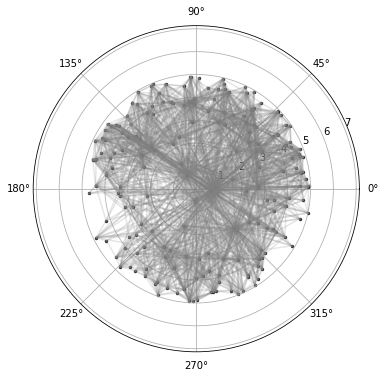

In [12]:
G.plot()

### Initialized (with noise)

In [ ]:
G_init = HRG(R=R, alpha=alpha, T=T)
G_init.r, G_init.theta, G_init.A = r_init, phi_init, A
G_init.plot()

### Estimated

In [ ]:
G_post = HRG(R=R_, alpha=alpha_, T=T_)
G_post.r, G_post.theta, G_post.A = rs_, c2d(phis_), A
G_post.plot()

In [ ]:
nodes = vi.posterior_samples(100)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
ax.scatter(theta.numpy(), r.numpy(), alpha=0.7, s=6, color='black')
for link in A.nonzero():
    ax.plot(theta[link].numpy(), r[link].numpy(), color='gray', alpha=0.2)
ax.set_rmax(R_*1.1)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show() 

In [ ]:
r_x_loc, r_x_scale, phi_x_loc, phi_x_scale, R_x_conc, R_x_scale, T_x, \
            alpha_x_conc, alpha_x_scale = vi.constrained_params()

In [ ]:
phi_x_scale

In [ ]:
torch.exp(torch.tensor(0.)).expand(10)

In [2]:
sigmoid = lambda x: 1/(1+x.exp())

In [35]:
x = torch.arange(1., 1e+6, 100)
R = torch.tensor(15.)
y = sigmoid((arcosh(x) - R)/(2*0.1))

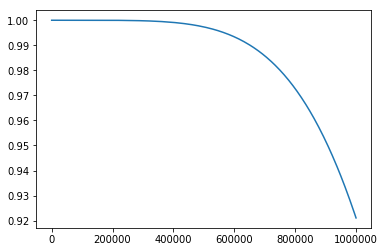

In [36]:
plt.plot(x.numpy(),y.numpy())

In [ ]:
y.shape

In [ ]:
f = lambda v, g: v*0.4*100/g

In [ ]:
f(110, 12)